In [1]:
# %load_ext nb_black
%load_ext autoreload
%autoreload 2

In [2]:
import muon as mu
import scanpy as sc
import umap
import pandas as pd
import numpy as np

from prismo.prismo import PRISMO, DataOptions, ModelOptions, TrainingOptions, SmoothOptions
from prismo.gpu import get_free_gpu_idx
from prismo.io import load_model
from prismo.downstream import match
from prismo.plotting import plot_training_curve, plot_variance_explained, plot_factor_correlation, plot_factors_scatter

/home/aqoku/miniconda3/envs/famo/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# plotting settings
# sns.set()
sns.set_theme()
sns.set_style("whitegrid")
sns.set_context("notebook")

In [5]:
def load_mdata(data="208", union=False, shuffle=False):

    if data == "208":
        path = "../../muvi-framework/data/sln_208.h5ad"
    if data == "111":
        path = "../../muvi-framework/data/sln_111.h5ad"

    relevant_cell_types = [
        "Activated CD4 T",
        # 'B doublets',
        # 'B-CD4 T cell doublets',
        # 'B-CD8 T cell doublets',
        # 'B-macrophage doublets',
        "B1 B",
        "CD122+ CD8 T",
        "CD4 T",
        "CD8 T",
        # 'Cycling B/T cells',
        "Erythrocytes",
        "GD T",
        "ICOS-high Tregs",
        "Ifit3-high B",
        "Ifit3-high CD4 T",
        "Ifit3-high CD8 T",
        # 'Low quality B cells',
        # 'Low quality T cells',
        "Ly6-high mono",
        "Ly6-low mono",
        "MZ B",
        "MZ/Marco-high macrophages",
        "Mature B",
        "Migratory DCs",
        "NK",
        "NKT",
        "Neutrophils",
        "Plasma B",
        "Red-pulp macrophages",
        # 'T doublets',
        "Transitional B",
        "Tregs",
        "cDC1s",
        "cDC2s",
        "pDCs",
    ]

    adata = sc.read_h5ad(path)
    adata.var_names_make_unique()
    adata.X = np.array(adata.X.todense(), dtype=np.float32)

    adata.obs_names = adata.obs_names.str.upper()
    adata.var_names = adata.var_names.str.upper()

    adata._inplace_subset_var(adata.var["highly_variable"])

    adata._inplace_subset_obs(adata.obs["cell_types"].isin(relevant_cell_types))
    adata.obs["cell_types"] = adata.obs["cell_types"].cat.remove_unused_categories()
    adata.obs["source"] = data

    prot_df = pd.DataFrame(
        adata.obsm["protein_expression"],
        index=adata.obs_names,
        columns=pd.Index(adata.uns["protein_names"]).str.upper(),
        dtype=np.float32,
    )
    if not union:
        prot_df = prot_df.dropna(axis=1, how="all")
    if shuffle:
        shuffled_obs = adata.obs_names[np.random.permutation(adata.n_obs)]
        adata = adata[shuffled_obs, :].copy()
        prot_df = prot_df.loc[shuffled_obs, :].copy()
    prot_adata = sc.AnnData(prot_df)
    return mu.MuData(
        {
            "rna": adata,
            "prot": prot_adata,
        }
    )

In [6]:
def merge_mdata(mdata_1, mdata_2):
    adata_dict = {}
    for k in mdata_1.mod.keys():
        df_1 = mdata_1[k].to_df()
        obs_1 = mdata_1[k].obs.copy()
        var_1 = mdata_1[k].var.copy()

        df_2 = mdata_2[k].to_df()
        obs_2 = mdata_2[k].obs.copy()
        var_2 = mdata_2[k].var.copy()
        # assert (var_1 == var_2).all(None)

        df_concat = pd.concat([df_1, df_2])
        unique_indices = ~df_concat.index.duplicated(False)
        df_concat = df_concat.loc[unique_indices, :].copy()
        # assert (df_1.columns == df_concat.columns).all()

        obs_1["source"] = 1
        obs_2["source"] = 2
        obs_concat = pd.concat([obs_1, obs_2]).loc[unique_indices, :].copy()

        adata_dict[k] = sc.AnnData(df_concat, obs=obs_concat, var=var_1)

    return mu.MuData(adata_dict)

In [7]:
mdata_208 = load_mdata("208", shuffle=False)
mdata_111 = load_mdata("111", shuffle=False)

# TODO: IF YOU MERGE MAKE SURE TO SET shuffle=False!
# mdata = merge_mdata(mdata_208, mdata_111)
mdata = mdata_208
mdata

/home/aqoku/miniconda3/envs/famo/lib/python3.10/site-packages/mudata/_core/mudata.py:1531: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
/home/aqoku/miniconda3/envs/famo/lib/python3.10/site-packages/mudata/_core/mudata.py:1429: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
/home/aqoku/miniconda3/envs/famo/lib/python3.10/site-packages/mudata/_core/mudata.py:1531: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on

MuData object with n_obs × n_vars = 14870 × 4112
  2 modalities
    rna:	14870 x 4000
      obs:	'n_proteins', 'batch_indices', 'n_genes', 'percent_mito', 'leiden_subclusters', 'cell_types', 'tissue', 'batch', 'source'
      var:	'gene_ids', 'feature_types', 'highly_variable', 'encode', 'hvg_encode'
      uns:	'protein_names', 'version'
      obsm:	'isotypes_htos', 'protein_expression'
    prot:	14870 x 112

In [8]:
cell_type_map = {
    "Mature B": "B",
    "Transitional B": "B",
    "Ifit3-high B": "B",
    "MZ B": "B",
    "B1 B": "B",
    "Plasma B": "B",
    "CD4 T": "CD4",
    "Ifit3-high CD4 T": "CD4",
    "Activated CD4 T": "CD4",
    "CD8 T": "CD8",
    "CD122+ CD8 T": "CD8",
    "Ifit3-high CD8 T": "CD8",
    "Tregs": "Tregs",
    "ICOS-high Tregs": "Tregs",
    # 'GD T': 'GD T',
    "NKT": "NK",
    "NK": "NK",
    "Neutrophils": "Neutrophils",
    "Ly6-high mono": "Ly6",
    "Ly6-low mono": "Ly6",
    "cDC2s": "DC",
    "cDC1s": "DC",
    "Migratory DCs": "DC",
    "pDCs": "DC",
    "Erythrocytes": "Erythrocytes",
    "MZ/Marco-high macrophages": "Macrophages",
    "Red-pulp macrophages": "Macrophages",
}


mdata["rna"].obs["cell types (high)"] = (
    mdata.obs["rna:cell_types"].map(cell_type_map).astype("category")
)

In [9]:
mdata.obs["rna:batch"].value_counts()

rna:batch
SLN208-D1    8265
SLN208-D2    6605
Name: count, dtype: int64

In [10]:
center = False
for view_name, adata in mdata.mod.items():
    adata.X = np.log1p(adata.X)
    if center:
        adata.X = adata.X - np.nanmean(adata.X, axis=0)
    else:
        adata.X = adata.X - np.nanmin(adata.X, axis=0)
    print(f"Current shape of {view_name}: {adata.shape}")
    global_std = np.nanstd(adata.X)
    print(f"Global std of {view_name} before: {global_std}")
    adata.X /= global_std
    print(f"Global std of {view_name}: {np.nanstd(adata.X)}")

mdata.update()

Current shape of rna: (14870, 4000)
Global std of rna before: 0.3643924295902252
Global std of rna: 0.9999992847442627
Current shape of prot: (14870, 112)
Global std of prot before: 1.142163634300232
Global std of prot: 1.0000001192092896


/home/aqoku/miniconda3/envs/famo/lib/python3.10/site-packages/mudata/_core/mudata.py:1531: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
/home/aqoku/miniconda3/envs/famo/lib/python3.10/site-packages/mudata/_core/mudata.py:1429: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.


<Axes: >

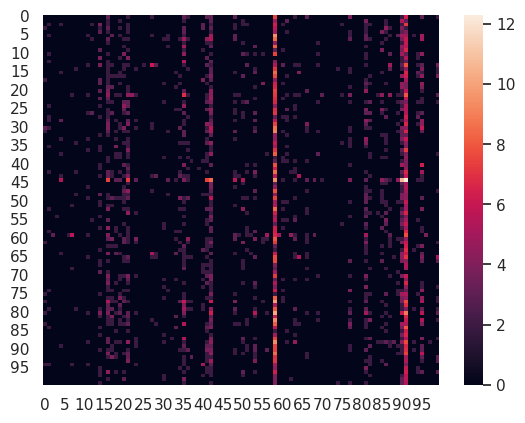

In [11]:
# visual check
sns.heatmap(mdata["rna"].X[:100, :100])

For this analysis we extract the prior information from well established databases of gene set collections such as the [MSigDB](http://www.gsea-msigdb.org/gsea/msigdb) and [Reactome](https://reactome.org/). We keep only those gene set annotations with at least 15 genes, and where at least 10% of the genes are available in the set of genes from RNA.

In [12]:
from prismo import feature_sets

In [13]:
def to_upper(feature_set_collection):
    return feature_sets.FeatureSets(
        [
            feature_sets.FeatureSet([f.upper() for f in fs], fs.name)
            for fs in feature_set_collection
        ],
        name=feature_set_collection.name,
    )

In [14]:
hallmark_collection = feature_sets.from_gmt(
    "../../muvi-framework/msigdb/mh.all.v2023.2.Mm.symbols.gmt", name="hallmark"
)
reactome_collection = feature_sets.from_gmt(
    "../../muvi-framework/msigdb/m2.cp.reactome.v2023.2.Mm.symbols.gmt", name="reactome"
)

# celltype_collection = feature_sets.from_gmt(
#     "../msigdb/m8.all.v2023.2.Mm.symbols.gmt", name="celltype"
# )

celltype_collection = feature_sets.from_gmt(
    "../../muvi-framework/raw_signatures/mmc5_gene.gmt", name="celltype"
)

# merge both collections
gene_set_collection = hallmark_collection | celltype_collection
gene_set_collection = to_upper(gene_set_collection)

In [15]:
# sorted([fs.name for fs in gene_set_collection if "HAN" in fs.name])

We keep only those gene set annotations with at least 15 genes, and where at least 10% of the genes are available in the set of genes from RNA.

In [16]:
gene_set_collection = gene_set_collection.filter(
    mdata["rna"].var_names, min_fraction=0.1, min_count=15, max_count=300
)
# sorted([fs.name for fs in gene_set_collection])
gene_set_collection

<FeatureSets 'hallmark|celltype' with 56 feature sets>

In [17]:
gene_set_collection.median_size

69

In [18]:
mdata["rna"].varm["gene_set_mask"] = gene_set_collection.to_mask(
    mdata["rna"].var_names.tolist()
).T

In [19]:
mdata["prot"].varm["gene_set_mask"] = pd.DataFrame(False, index=mdata["prot"].var_names, columns=mdata["rna"].varm["gene_set_mask"].columns)

In [20]:
device = "cpu"
try:
    device = f"cuda:{get_free_gpu_idx()}"
except Exception as e:
    print(e)
device

'cuda:1'

In [21]:
data_opts = DataOptions(
    group_by=None, 
    scale_per_group=True, 
    covariates_obs_key=None, 
    covariates_obsm_key=None, 
    use_obs=None, 
    use_var=None, 
    plot_data_overview=False
)

In [22]:
model_opts = ModelOptions(
    n_factors=3,
    weight_prior="Horseshoe",
    factor_prior="Normal",
    likelihoods="Normal",
    nonnegative_weights=True,
    nonnegative_factors=True,
    annotations=None,
    annotations_varm_key={"rna": "gene_set_mask"},
    prior_penalty=0.003,
    init_factors="random",
    init_scale=0.1
)

In [23]:
training_opts = TrainingOptions(
    device=device, 
    batch_size=0,
    max_epochs=10000, 
    n_particles=1, 
    lr=0.005, 
    early_stopper_patience=100, 
    print_every=500, 
    save=False, 
    save_path=None, 
    # 2411091114
    # 2411091110
    seed=2411091114
)

In [24]:
model = PRISMO()
model.fit(
    mdata,
    data_opts,
    model_opts,
    training_opts
)

/home/aqoku/miniconda3/envs/famo/lib/python3.10/site-packages/mudata/_core/mudata.py:1531: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
/home/aqoku/miniconda3/envs/famo/lib/python3.10/site-packages/mudata/_core/mudata.py:1429: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
2024-11-09 12:42:48 | prismo.prismo | INFO | Setting up device...
2024-11-09 12:42:48 | prismo.prismo | INFO | - Using provided likelihood for all views.
2024-11-09 12:42:48 | prismo.prismo | INFO |   - rna: Normal
2024-11-09 12:42:

In [25]:
from prismo import downstream

In [26]:
test_results = downstream.test(model)

2024-11-09 12:54:57 | prismo.downstream | WARNING | No feature sets provided, extracting feature sets from prior mask.
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:15<00:00,  3.55it/s]
2024-11-09 12:55:13 | prismo.downstream | WARNING | No feature sets provided, extracting feature sets from prior mask.
2024-11-09 12:55:13 | prismo.downstream | WARNING | Empty `feature_sets`, view `prot` has not been informed prior to training.
2024-11-09 12:55:13 | prismo.downstream | WARNING | No feature sets provided, extracting feature sets from prior mask.
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:16<00:00,  3.50it/s]
2024-11-09 12:55:30 | prismo.downstream | WARNING | No feature sets provided, extracting feature sets from prior mask.
2024-11-09 12:55:30 | prismo.downstream | WARNING | Empty `feature_sets`, view `prot` has not been informed prior to 

In [27]:
p_adj_df = test_results["pos"]["rna"]["p_adj"].copy()
p_adj_df.head()

,HAN_MARGINAL ZONE B CELL,HAN_T CELL,HALLMARK_PROTEIN_SECRETION,HALLMARK_DNA_REPAIR,HAN_PLASMA CELL,HAN_GRANULOCYTE,HAN_MONOCYTE,HALLMARK_MYC_TARGETS_V1,HALLMARK_APICAL_JUNCTION,HAN_DENDRITIC CELL_S100A4 HIGH,...,HALLMARK_FATTY_ACID_METABOLISM,HALLMARK_PEROXISOME,HALLMARK_ANGIOGENESIS,HALLMARK_E2F_TARGETS,HALLMARK_MITOTIC_SPINDLE,HALLMARK_KRAS_SIGNALING_UP,HALLMARK_ESTROGEN_RESPONSE_LATE,HALLMARK_BILE_ACID_METABOLISM,HALLMARK_CHOLESTEROL_HOMEOSTASIS,HALLMARK_GLYCOLYSIS
Factor 3,9.982884e-01,9.982884e-01,1.000000,1.000000,0.998288,0.998288,0.998288,0.998288,0.998288,0.998288,...,0.998288,1.000000,1.00000,1.000000,1.0,1.00000,1.0,1.00000,0.998288,0.998288
Factor 2,9.955358e-01,1.000000e+00,1.000000,1.000000,0.995536,0.995536,0.995536,0.995536,0.995536,0.995536,...,1.000000,1.000000,1.00000,1.000000,1.0,1.00000,1.0,1.00000,0.995536,1.000000
Factor 1,9.955312e-01,9.279363e-01,0.927936,0.927936,0.668344,0.927936,0.927936,0.001181,0.951019,0.927936,...,0.668344,0.927936,1.00000,0.927936,1.0,1.00000,1.0,1.00000,0.951019,0.927936
HAN_MARGINAL ZONE B CELL,4.442838e-37,1.000000e+00,1.000000,1.000000,0.288087,0.984998,0.981009,1.000000,1.000000,0.981009,...,1.000000,1.000000,1.00000,1.000000,1.0,1.00000,1.0,1.00000,1.000000,1.000000
HAN_T CELL,1.000000e+00,4.219117e-42,1.000000,1.000000,1.000000,0.993110,0.993110,0.993110,0.993110,1.000000,...,0.993110,1.000000,0.99311,1.000000,1.0,0.99311,1.0,0.99311,1.000000,1.000000


In [28]:
pd.Series(np.diagonal(p_adj_df.loc[p_adj_df.columns, p_adj_df.columns]), index=p_adj_df.columns) < 0.05

HAN_MARGINAL ZONE B CELL                       True
HAN_T CELL                                     True
HALLMARK_PROTEIN_SECRETION                    False
HALLMARK_DNA_REPAIR                           False
HAN_PLASMA CELL                                True
HAN_GRANULOCYTE                               False
HAN_MONOCYTE                                   True
HALLMARK_MYC_TARGETS_V1                       False
HALLMARK_APICAL_JUNCTION                      False
HAN_DENDRITIC CELL_S100A4 HIGH                 True
HALLMARK_INTERFERON_ALPHA_RESPONSE             True
HAN_NK CELL                                    True
HALLMARK_NOTCH_SIGNALING                       True
HALLMARK_INFLAMMATORY_RESPONSE                 True
HALLMARK_KRAS_SIGNALING_DN                     True
HAN_MACROPHAGE                                False
HAN_DENDRITIC CELL_SIGLECH HIGH                True
HALLMARK_P53_PATHWAY                          False
HAN_NEUTROPHIL                                 True
HALLMARK_OXI

In [29]:
from prismo import plotting

In [30]:
from plotting import groupplot_rank, scatter

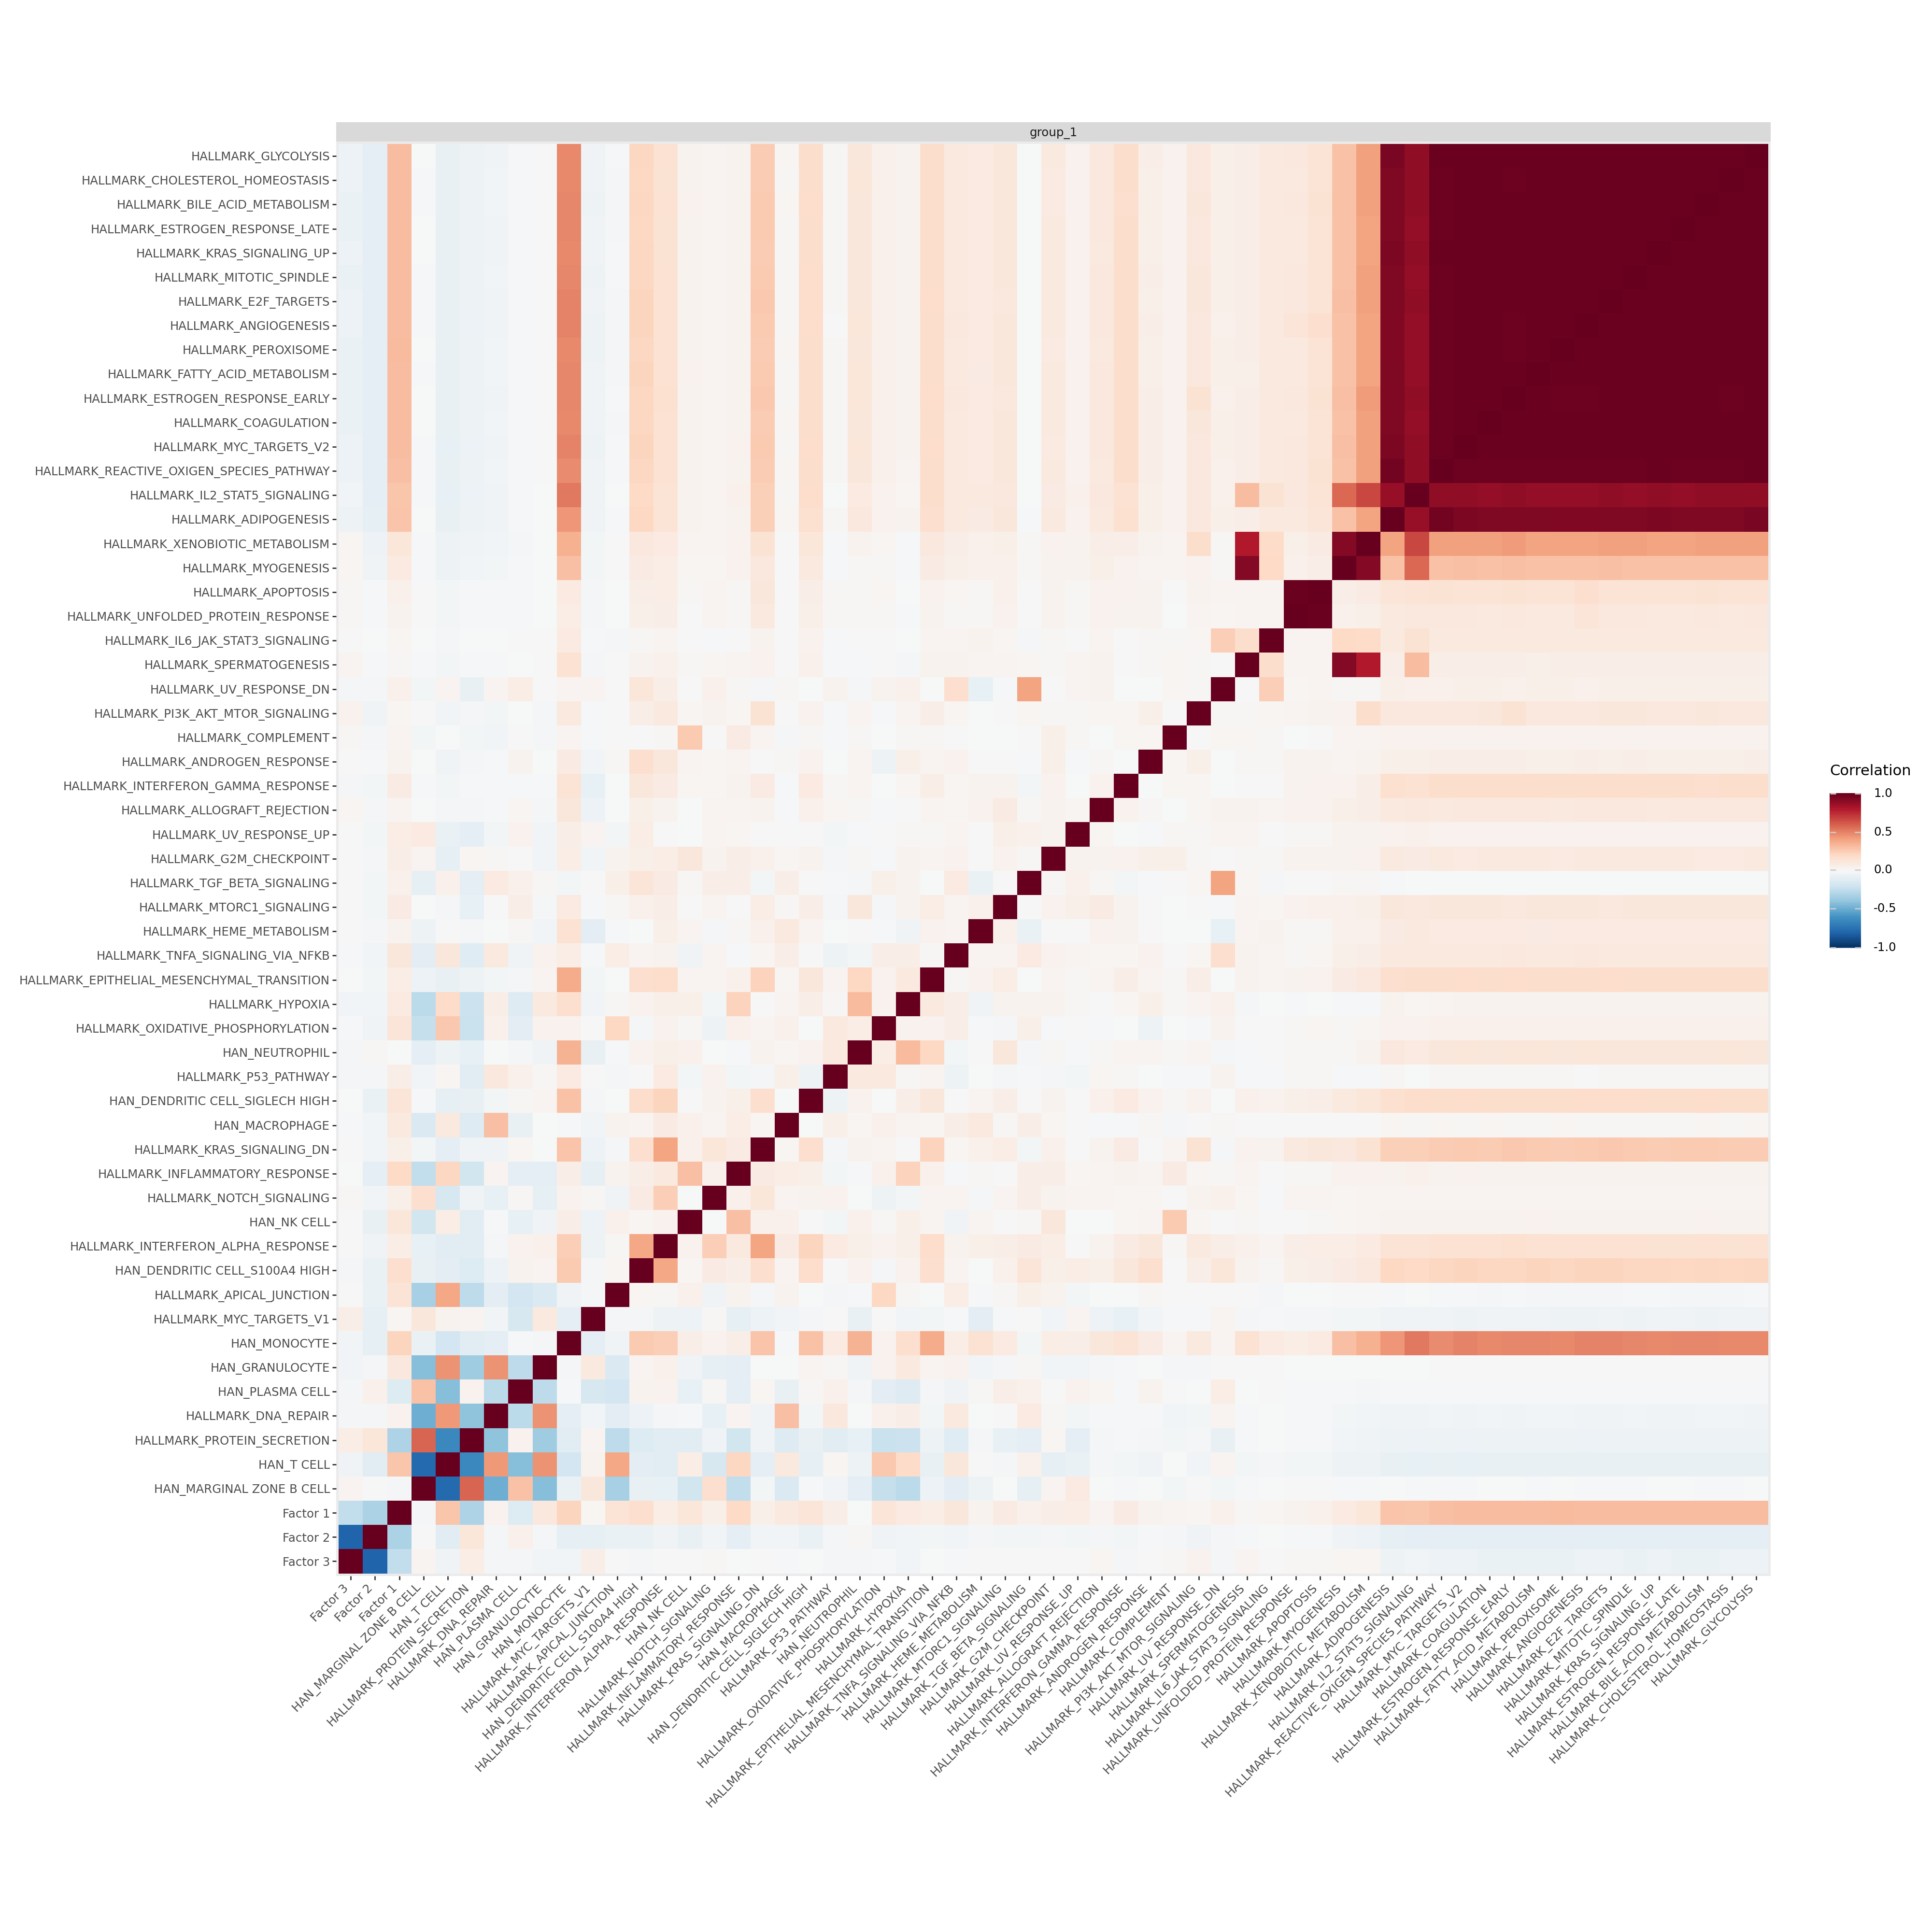

In [31]:
plotting.plot_factor_correlation(model, figsize=(20, 20))

In [53]:
factor_adata = model.get_factors("anndata")["group_1"].copy()
factor_adata

AnnData object with n_obs × n_vars = 14870 × 59
    obs: 'n_proteins', 'batch_indices', 'n_genes', 'percent_mito', 'leiden_subclusters', 'cell_types', 'tissue', 'batch', 'source', 'cell types (high)'

In [54]:
sc.pp.neighbors(factor_adata, use_rep="X")
sc.tl.umap(factor_adata)

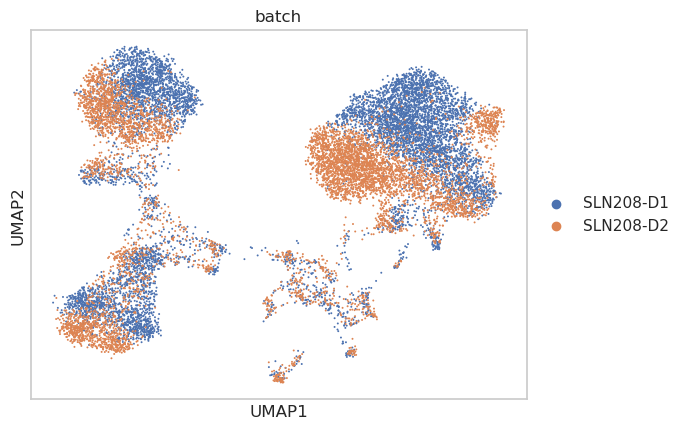

In [55]:
sc.pl.umap(factor_adata, color="batch", size=8)

In [56]:
sc.tl.rank_genes_groups(
    factor_adata, "batch", method="wilcoxon"
)

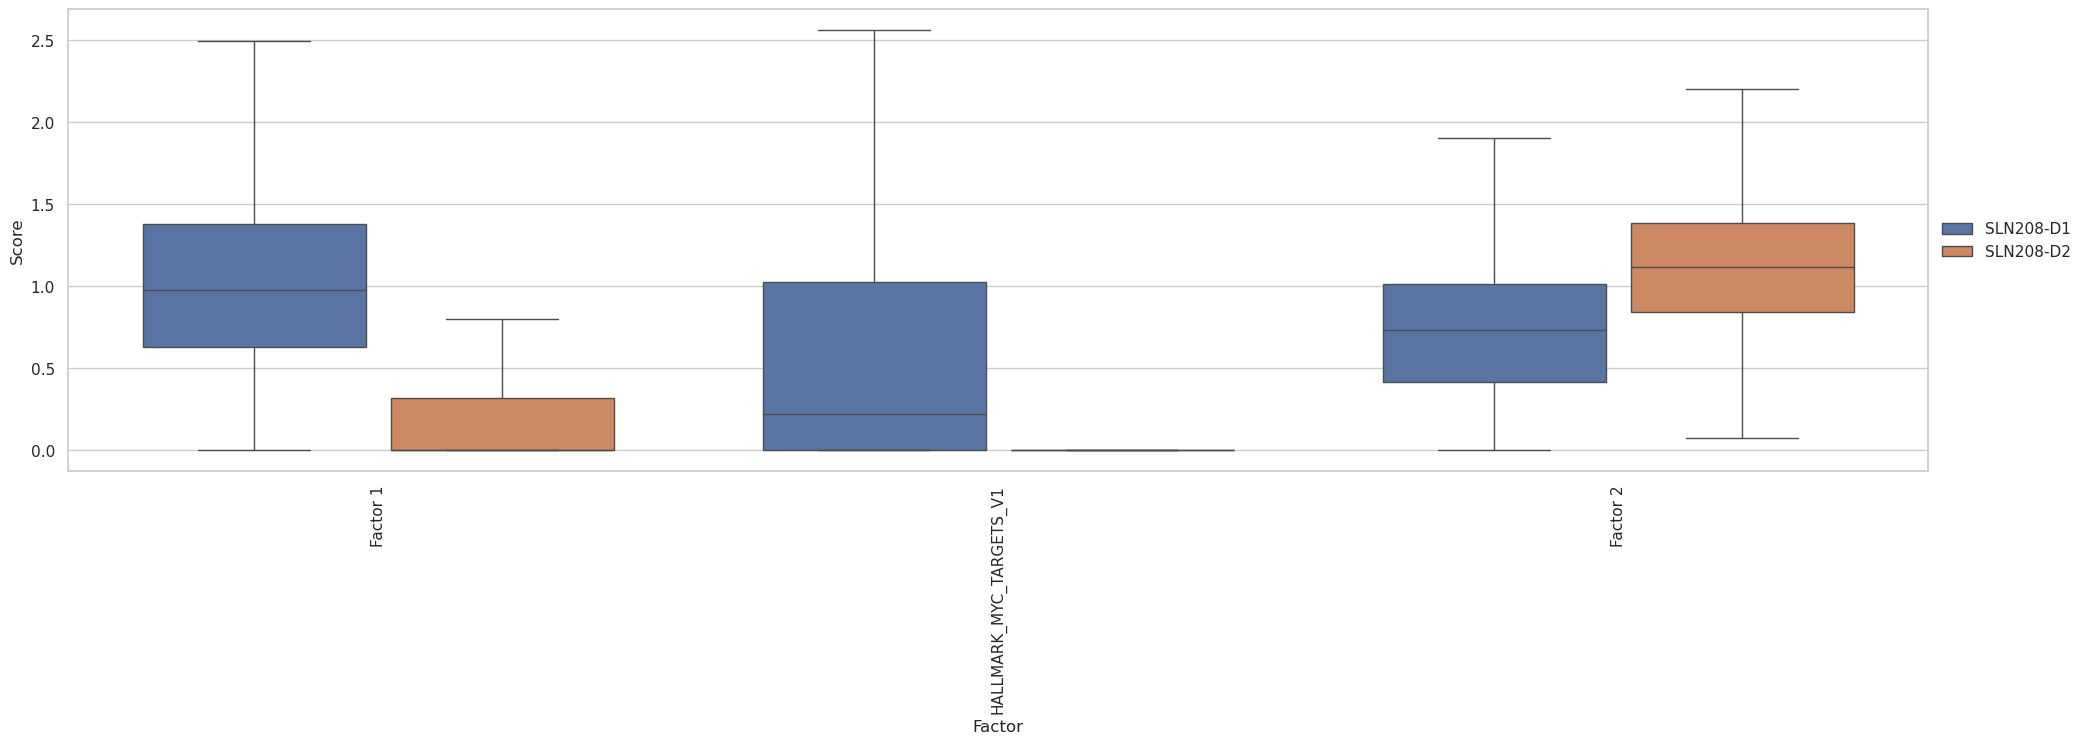

In [57]:
plt.figure(figsize=(24, 6))
batch_factors, _ = groupplot_rank(
    model, "batch", group_idx="group_1", pl_type="boxplot", top=3, gap=0.1, showfliers=False, rot=90
)

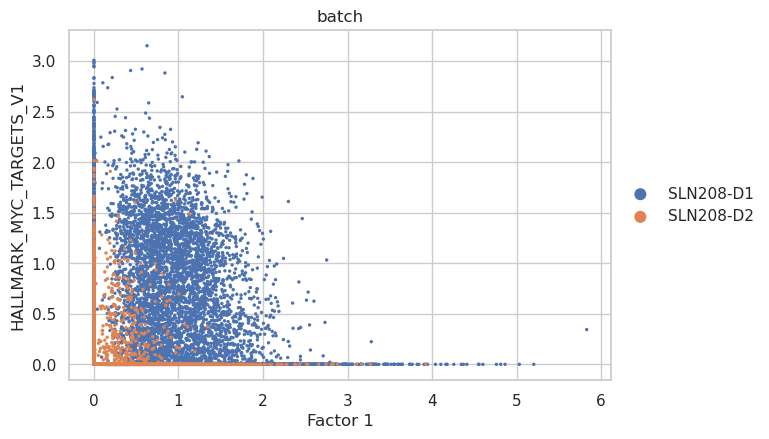

In [58]:
scatter(model, batch_factors[0], batch_factors[1], "group_1", groupby="batch", size=24)

In [59]:
factor_adata = factor_adata[:, [fn for fn in model.factor_names if fn not in batch_factors]].copy()
factor_adata

AnnData object with n_obs × n_vars = 14870 × 56
    obs: 'n_proteins', 'batch_indices', 'n_genes', 'percent_mito', 'leiden_subclusters', 'cell_types', 'tissue', 'batch', 'source', 'cell types (high)'
    uns: 'neighbors', 'umap', 'batch_colors', 'rank_genes_groups'
    obsm: 'X_umap'
    obsp: 'distances', 'connectivities'

In [60]:
sc.pp.neighbors(factor_adata, use_rep="X")
sc.tl.umap(factor_adata)

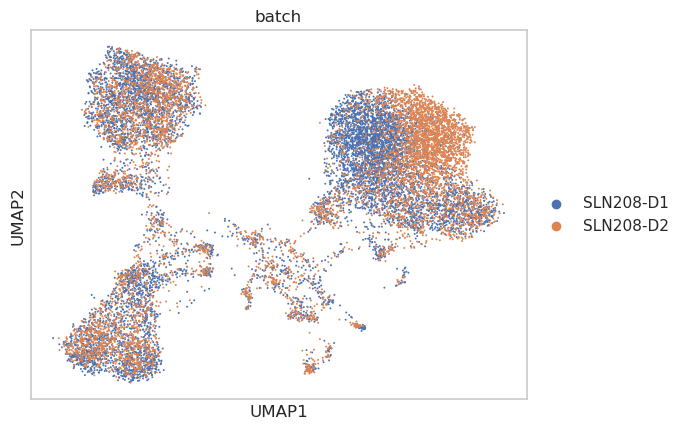

In [61]:
sc.pl.umap(factor_adata, color="batch", size=8)

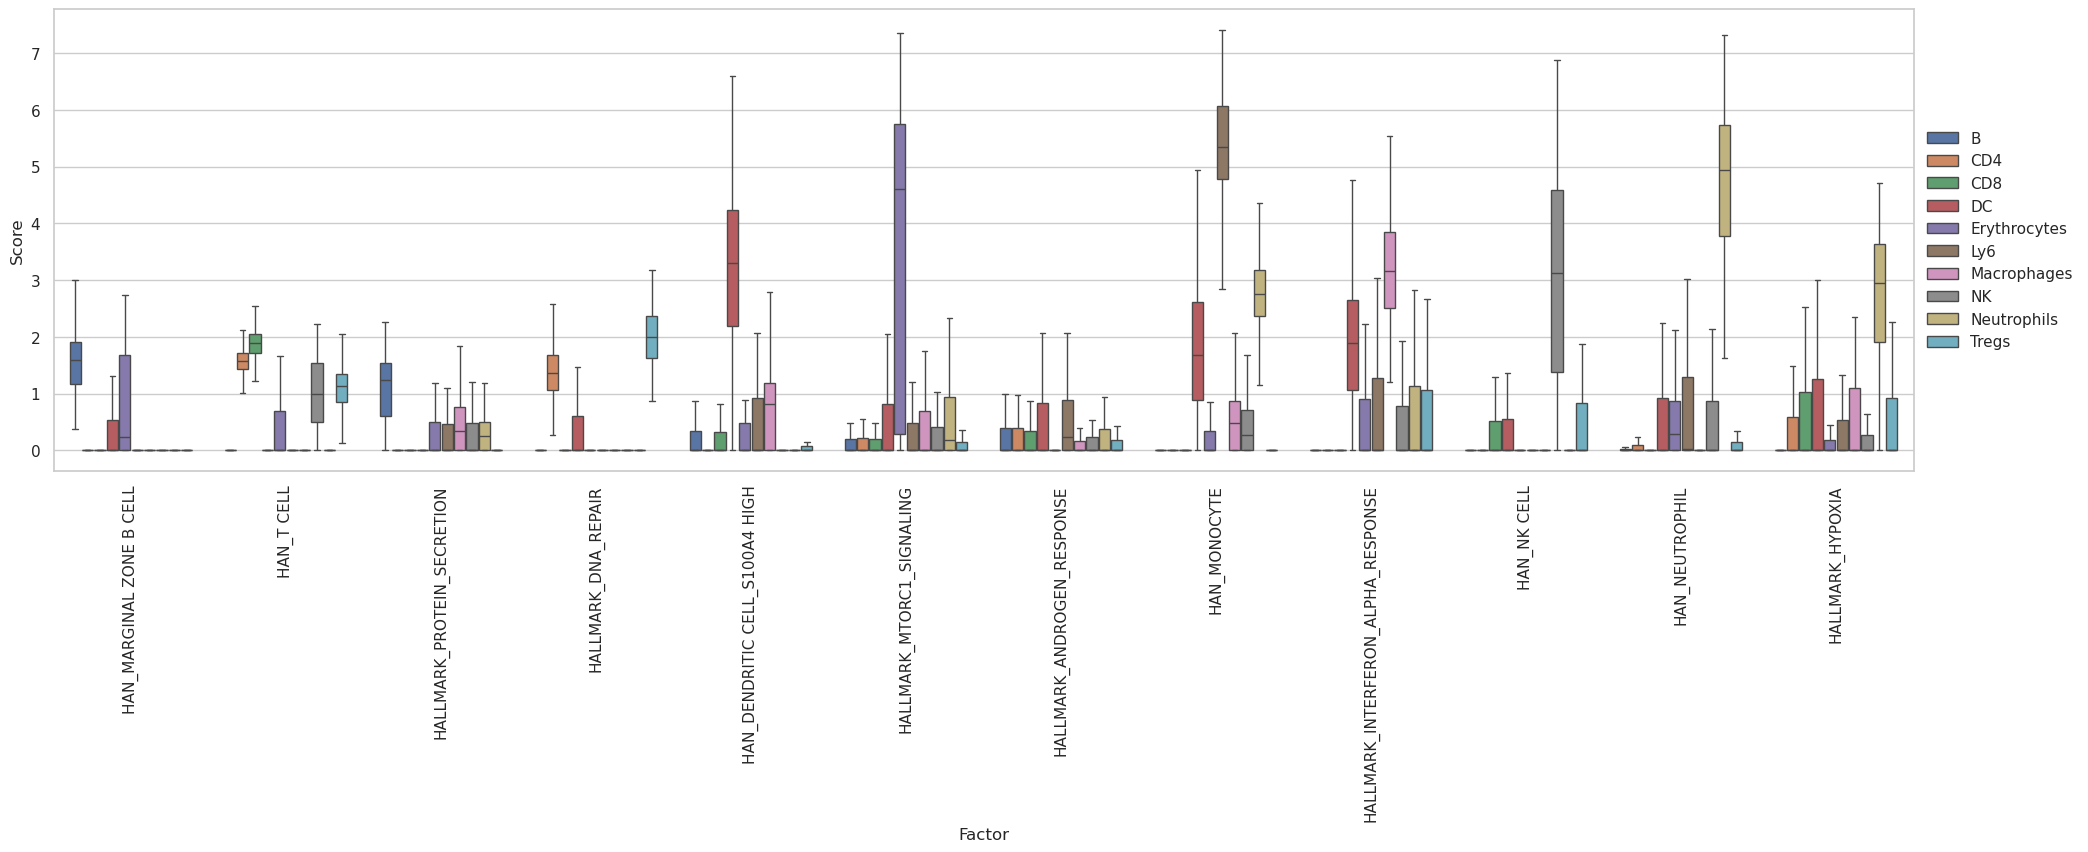

In [62]:
plt.figure(figsize=(24, 6))
celltype_factors, _ = groupplot_rank(
    model, "cell types (high)", group_idx="group_1", pl_type="boxplot", top=3, gap=0.1, showfliers=False, rot=90
)

In [63]:
from plotting import plot_top_weights

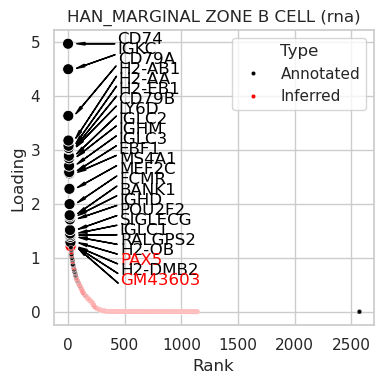

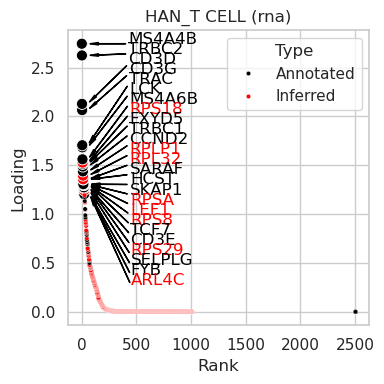

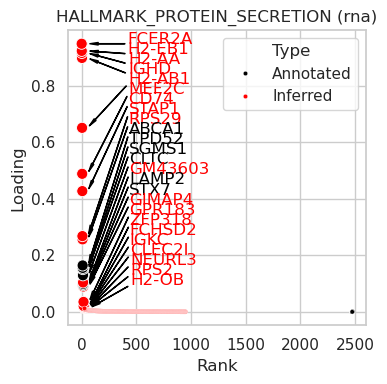

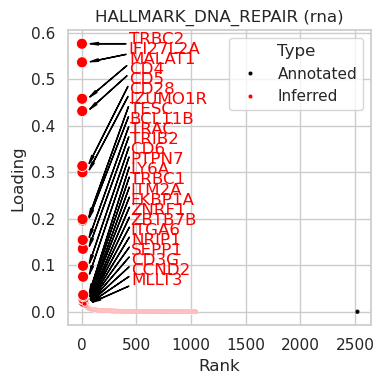

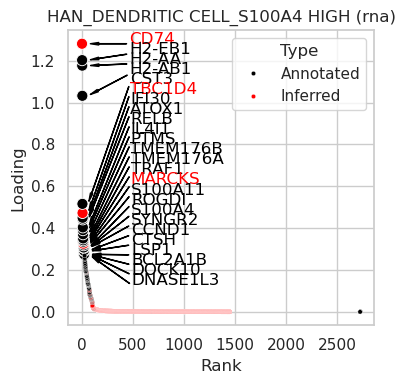

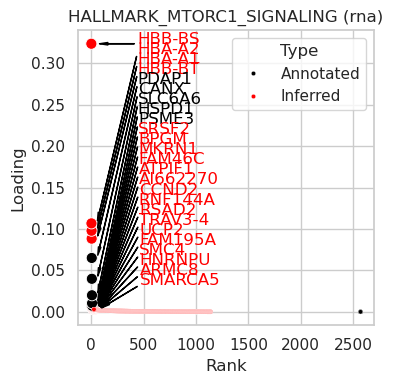

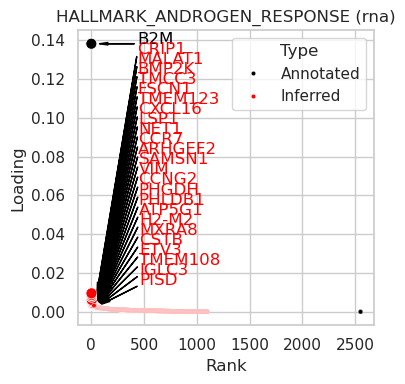

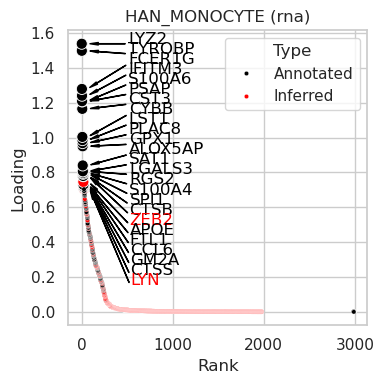

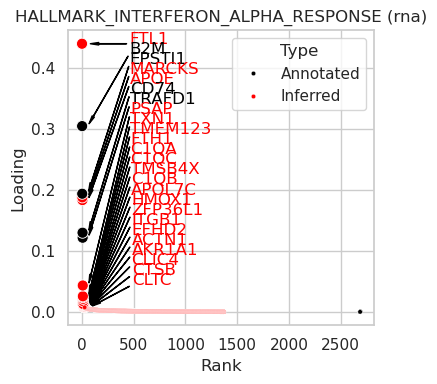

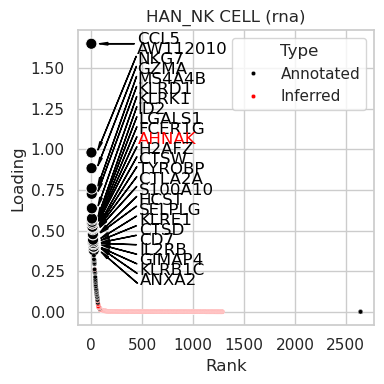

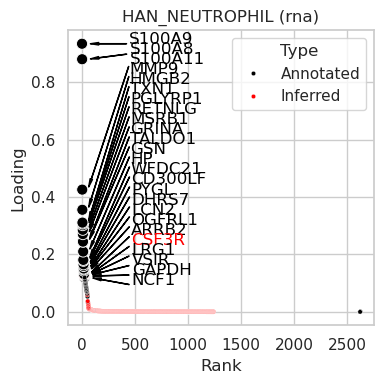

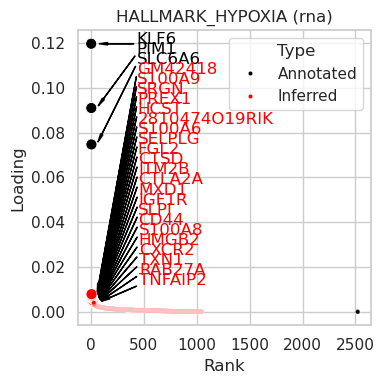

In [64]:
for rf in celltype_factors:
    plot_top_weights(model, rf, view_idx="rna", top=25, ranked=True, figsize=(4,4))
    plt.show()